# Análise de Métricas de Scheduling Results

Este notebook processa os 3 datasets de resultados de agendamento e calcula as métricas:
- **Recall@1**: Taxa de acerto na primeira recomendação
- **Recall@5**: Taxa de acerto nas 5 primeiras recomendações  
- **IEuc**: Métrica de eficiência euclidiana baseada na distância inversa

## Datasets analisados:
1. `10_last_scheduling_results.csv` - Resultados baseados nas últimas 10 tarefas
2. `week_scheduling_results.csv` - Resultados baseados na última semana
3. `month_scheduling_results.csv` - Resultados baseados no último mês

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Configurar estilo dos gráficos
plt.style.use('default')
sns.set_palette("husl")

print("✅ Bibliotecas importadas com sucesso")

✅ Bibliotecas importadas com sucesso


In [33]:
# Caminhos para os datasets
data_path = Path('../../data/results')
datasets = {
    '10_last': data_path / '10_last_tasks_scheduling_results.csv',
    'week': data_path / 'week_scheduling_results.csv',
    'month': data_path / 'month_scheduling_results.csv'
}

# Carregar os datasets
dataframes = {}
for name, path in datasets.items():
    if path.exists():
        df = pd.read_csv(path)
        dataframes[name] = df
        print(f"✅ {name}: {len(df)} registros carregados")
        print(f"   Colunas: {list(df.columns)}")
    else:
        print(f"❌ Arquivo não encontrado: {path}")

print(f"\n📊 Total de datasets carregados: {len(dataframes)}")

✅ 10_last: 143 registros carregados
   Colunas: ['task_index', 'original_time_slot', 'predicted_time_slot', 'recall_at_1', 'recall_at_5', 'tokens_spent']
✅ week: 143 registros carregados
   Colunas: ['task_index', 'original_time_slot', 'predicted_time_slot', 'recall_at_1', 'recall_at_5', 'tokens_spent']
✅ month: 143 registros carregados
   Colunas: ['task_index', 'original_time_slot', 'predicted_time_slot', 'recall_at_1', 'recall_at_5', 'tokens_spent']

📊 Total de datasets carregados: 3


In [34]:
# Explorar a estrutura dos dados
print("=== ESTRUTURA DOS DATASETS ===\n")

for name, df in dataframes.items():
    print(f"📈 Dataset: {name}")
    print(f"   Shape: {df.shape}")
    print(f"   Tipos de dados:")
    for col in df.columns:
        unique_vals = df[col].nunique()
        print(f"      {col}: {df[col].dtype} ({unique_vals} valores únicos)")

    print(f"   Primeiras 3 linhas:")
    print(df.head(3).to_string(index=False))

    print(f"   Últimas 3 linhas:")
    print(df.tail(3).to_string(index=False))
    print("-" * 60)

=== ESTRUTURA DOS DATASETS ===

📈 Dataset: 10_last
   Shape: (143, 6)
   Tipos de dados:
      task_index: int64 (143 valores únicos)
      original_time_slot: int64 (73 valores únicos)
      predicted_time_slot: int64 (62 valores únicos)
      recall_at_1: bool (2 valores únicos)
      recall_at_5: bool (2 valores únicos)
      tokens_spent: int64 (43 valores únicos)
   Primeiras 3 linhas:
 task_index  original_time_slot  predicted_time_slot  recall_at_1  recall_at_5  tokens_spent
          0                  95                    0        False        False           493
          1                 118                   95        False        False           555
          2                 104                  118        False        False           617
   Últimas 3 linhas:
 task_index  original_time_slot  predicted_time_slot  recall_at_1  recall_at_5  tokens_spent
        140                  41                   38        False        False          1079
        141                

## Cálculo das Métricas

### Definição das Métricas:

**Recall@1**: Proporção de casos onde a tarefa correta foi encontrada na primeira posição
- Fórmula: `(Número de True em recall_at_1) / (Total de casos)`

**Recall@5**: Proporção de casos onde a tarefa correta foi encontrada entre as 5 primeiras posições  
- Fórmula: `(Número de True em recall_at_5) / (Total de casos)`

**IEuc (Inverse Euclidean)**: Métrica de eficiência baseada na distância euclidiana inversa
- Fórmula: `1 / sqrt(1 + distância_ao_alvo²)`
- Para recall_at_1 = True: distância = 0 (IEuc = 1.0)
- Para recall_at_5 = True (mas não @1): distância estimada baseada na posição
- Para ambos False: distância máxima (IEuc próximo a 0)

In [35]:
import math

def calculate_ieuc(pred_slot: int, true_slot: int, hours_per_day: int = 24) -> float:
    """
    Converte cada slot em (dia, hora), mede a distância Euclidiana e
    devolve o inverso (1/(d+1)).
    """
    d_pred, h_pred  = divmod(pred_slot, hours_per_day)
    d_true, h_true  = divmod(true_slot, hours_per_day)
    dist            = math.hypot(d_pred - d_true, h_pred - h_true)
    return 1.0 / (dist + 1.0)

# Calculate IEuc using ieuc_slot function for all datasets
for name, df in dataframes.items():
    ieuc_values = []

    for predicted_slot, true_slot in zip(df["predicted_time_slot"], df["original_time_slot"]):
        ieuc_value = calculate_ieuc(predicted_slot, true_slot)
        ieuc_values.append(ieuc_value)

    df["ieuc"] = ieuc_values
    print(f"✅ IEuc calculado para dataset {name}: média = {df['ieuc'].mean():.4f}")
    print(f"📋 5 primeiras linhas do dataset {name}:")
    print(df.head(5).to_string())
    print()  # linha em branco para separar datasets

✅ IEuc calculado para dataset 10_last: média = 0.2174
📋 5 primeiras linhas do dataset 10_last:
   task_index  original_time_slot  predicted_time_slot  recall_at_1  recall_at_5  tokens_spent      ieuc
0           0                  95                    0        False        False           493  0.041331
1           1                 118                   95        False        False           555  0.414214
2           2                 104                  118        False        False           617  0.066667
3           3                  67                  104        False        False           676  0.082100
4           4                 111                   67        False        False           736  0.182744

✅ IEuc calculado para dataset week: média = 0.1301
📋 5 primeiras linhas do dataset week:
   task_index  original_time_slot  predicted_time_slot  recall_at_1  recall_at_5  tokens_spent      ieuc
0           0                  95                   48        False        False

In [36]:
# Calcular métricas para cada dataset
results = {}

print("=== CÁLCULO DAS MÉTRICAS ===\n")

for name, df in dataframes.items():
    # Recall@1: proporção de True em recall_at_1
    recall_1 = df['recall_at_1'].mean()

    # Recall@5: proporção de True em recall_at_5
    recall_5 = df['recall_at_5'].mean()

    # IEuc: aplicar função para cada linha e fazer média
    df['ieuc'] = df.apply(lambda row: calculate_ieuc(row['predicted_time_slot'], row['original_time_slot']), axis=1)
    ieuc_mean = df['ieuc'].mean()

    # Tokens gastos: média e total
    tokens_mean = df['tokens_spent'].mean()
    tokens_total = df['tokens_spent'].sum()

    # Armazenar resultados
    results[name] = {
        'recall_at_1': recall_1,
        'recall_at_5': recall_5,
        'ieuc': ieuc_mean,
        'tokens_mean': tokens_mean,
        'tokens_total': tokens_total,
        'total_tasks': len(df)
    }

    print(f"📊 Dataset: {name}")
    print(f"   Recall@1: {recall_1:.4f} ({recall_1*100:.2f}%)")
    print(f"   Recall@5: {recall_5:.4f} ({recall_5*100:.2f}%)")
    print(f"   IEuc: {ieuc_mean:.4f}")
    print(f"   Tokens médios: {tokens_mean:.1f}")
    print(f"   Tokens totais: {tokens_total:.1f}")
    print(f"   Total de tarefas: {len(df)}")
    print("-" * 50)

print("✅ Métricas calculadas para todos os datasets")

=== CÁLCULO DAS MÉTRICAS ===

📊 Dataset: 10_last
   Recall@1: 0.0210 (2.10%)
   Recall@5: 0.1049 (10.49%)
   IEuc: 0.2174
   Tokens médios: 1067.0
   Tokens totais: 152586.0
   Total de tarefas: 143
--------------------------------------------------
📊 Dataset: week
   Recall@1: 0.0000 (0.00%)
   Recall@5: 0.0280 (2.80%)
   IEuc: 0.1301
   Tokens médios: 519.7
   Tokens totais: 74322.0
   Total de tarefas: 143
--------------------------------------------------
📊 Dataset: month
   Recall@1: 0.0070 (0.70%)
   Recall@5: 0.0490 (4.90%)
   IEuc: 0.1723
   Tokens médios: 581.1
   Tokens totais: 83097.0
   Total de tarefas: 143
--------------------------------------------------
✅ Métricas calculadas para todos os datasets


In [37]:
# Criar tabela resumo das métricas
summary_df = pd.DataFrame(results).T

# Reordenar colunas para melhor visualização
column_order = ['total_tasks', 'recall_at_1', 'recall_at_5', 'ieuc', 'tokens_mean', 'tokens_total']
summary_df = summary_df[column_order]

# Renomear colunas para melhor apresentação
summary_df.columns = ['Total Tasks', 'Recall@1', 'Recall@5', 'IEuc', 'Tokens (Mean)', 'Tokens (Total)']

print("=== TABELA RESUMO DAS MÉTRICAS ===\n")
print(summary_df.round(4).to_string())

# Converter percentuais para melhor visualização
display_df = summary_df.copy()
display_df['Recall@1'] = (display_df['Recall@1'] * 100).round(2).astype(str) + '%'
display_df['Recall@5'] = (display_df['Recall@5'] * 100).round(2).astype(str) + '%'
display_df['IEuc'] = display_df['IEuc'].round(4)
display_df['Tokens (Mean)'] = display_df['Tokens (Mean)'].round(1)
display_df['Tokens (Total)'] = display_df['Tokens (Total)'].astype(int)

print("\n=== TABELA FORMATADA ===\n")
print(display_df.to_string())

=== TABELA RESUMO DAS MÉTRICAS ===

         Total Tasks  Recall@1  Recall@5    IEuc  Tokens (Mean)  Tokens (Total)
10_last        143.0     0.021    0.1049  0.2174      1067.0350        152586.0
week           143.0     0.000    0.0280  0.1301       519.7343         74322.0
month          143.0     0.007    0.0490  0.1723       581.0979         83097.0

=== TABELA FORMATADA ===

         Total Tasks Recall@1 Recall@5    IEuc  Tokens (Mean)  Tokens (Total)
10_last        143.0     2.1%   10.49%  0.2174         1067.0          152586
week           143.0     0.0%     2.8%  0.1301          519.7           74322
month          143.0     0.7%     4.9%  0.1723          581.1           83097


## Visualizações Comparativas

Vamos criar gráficos para comparar as métricas entre os diferentes datasets.

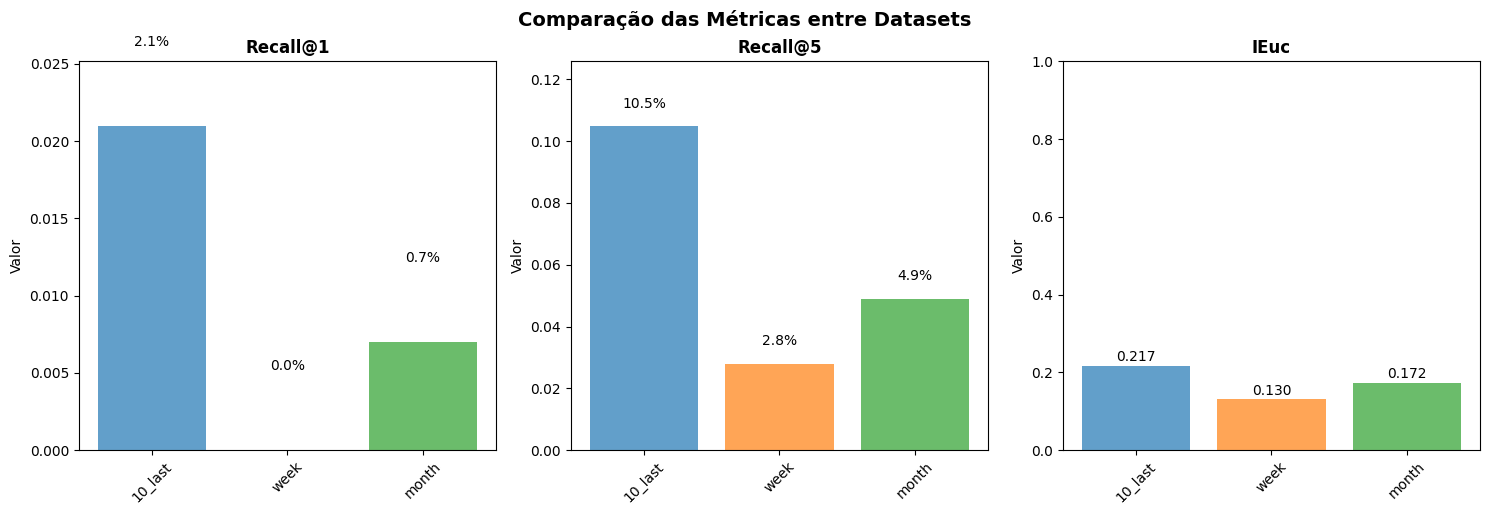

✅ Gráfico de métricas principais criado


In [38]:
# Gráfico de barras comparativo das métricas principais
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

metrics = ['Recall@1', 'Recall@5', 'IEuc']
original_metrics = ['recall_at_1', 'recall_at_5', 'ieuc']

for i, (metric, orig_metric) in enumerate(zip(metrics, original_metrics)):
    data = [results[dataset][orig_metric] for dataset in results.keys()]
    dataset_names = list(results.keys())

    bars = axes[i].bar(dataset_names, data, alpha=0.7,
                       color=['#1f77b4', '#ff7f0e', '#2ca02c'])

    # Adicionar valores no topo das barras
    for bar, value in zip(bars, data):
        height = bar.get_height()
        if metric in ['Recall@1', 'Recall@5']:
            axes[i].text(bar.get_x() + bar.get_width()/2., height + 0.005,
                        f'{value*100:.1f}%', ha='center', va='bottom')
        else:
            axes[i].text(bar.get_x() + bar.get_width()/2., height + 0.005,
                        f'{value:.3f}', ha='center', va='bottom')

    axes[i].set_title(f'{metric}', fontsize=12, fontweight='bold')
    axes[i].set_ylabel('Valor')
    axes[i].tick_params(axis='x', rotation=45)

    # Ajustar limites do y
    if metric in ['Recall@1', 'Recall@5']:
        axes[i].set_ylim(0, max(data) * 1.2)
    else:
        axes[i].set_ylim(0, 1.0)

plt.tight_layout()
plt.suptitle('Comparação das Métricas entre Datasets', fontsize=14, fontweight='bold', y=1.02)
plt.show()

print("✅ Gráfico de métricas principais criado")

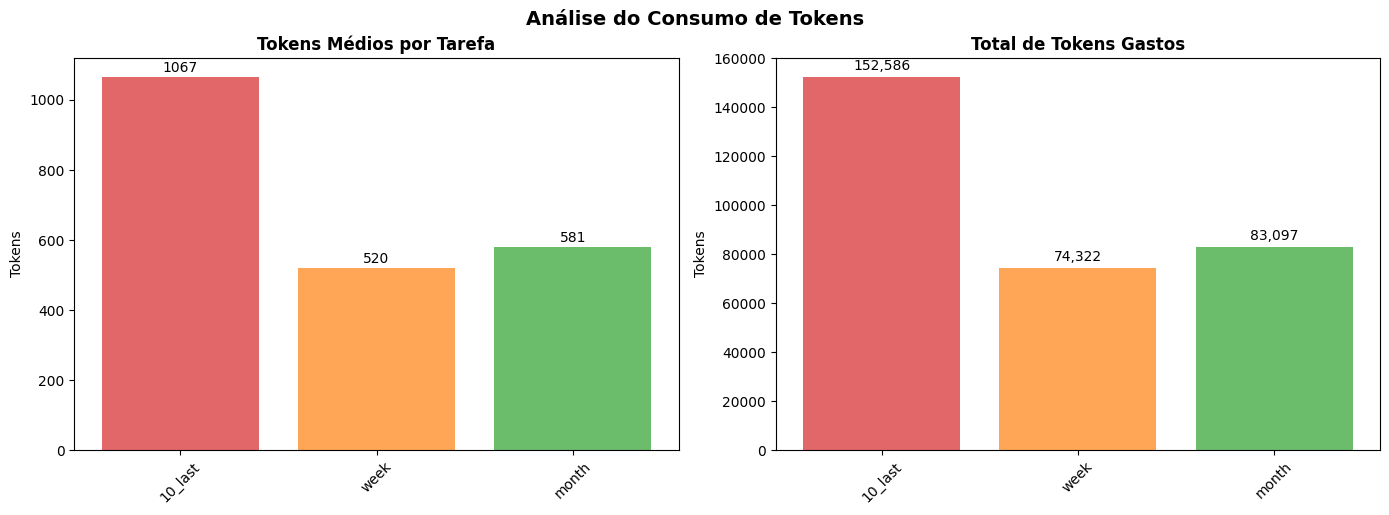

✅ Gráficos de consumo de tokens criados


In [39]:
# Análise do consumo de tokens
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Gráfico 1: Tokens médios por tarefa
dataset_names = list(results.keys())
tokens_mean = [results[dataset]['tokens_mean'] for dataset in dataset_names]

bars1 = axes[0].bar(dataset_names, tokens_mean, alpha=0.7, color=['#d62728', '#ff7f0e', '#2ca02c'])
for bar, value in zip(bars1, tokens_mean):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height + 5,
                f'{value:.0f}', ha='center', va='bottom')

axes[0].set_title('Tokens Médios por Tarefa', fontweight='bold')
axes[0].set_ylabel('Tokens')
axes[0].tick_params(axis='x', rotation=45)

# Gráfico 2: Total de tokens gastos
tokens_total = [results[dataset]['tokens_total'] for dataset in dataset_names]

bars2 = axes[1].bar(dataset_names, tokens_total, alpha=0.7, color=['#d62728', '#ff7f0e', '#2ca02c'])
for bar, value in zip(bars2, tokens_total):
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height + max(tokens_total)*0.01,
                f'{value:,}', ha='center', va='bottom')

axes[1].set_title('Total de Tokens Gastos', fontweight='bold')
axes[1].set_ylabel('Tokens')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.suptitle('Análise do Consumo de Tokens', fontsize=14, fontweight='bold', y=1.02)
plt.show()

print("✅ Gráficos de consumo de tokens criados")

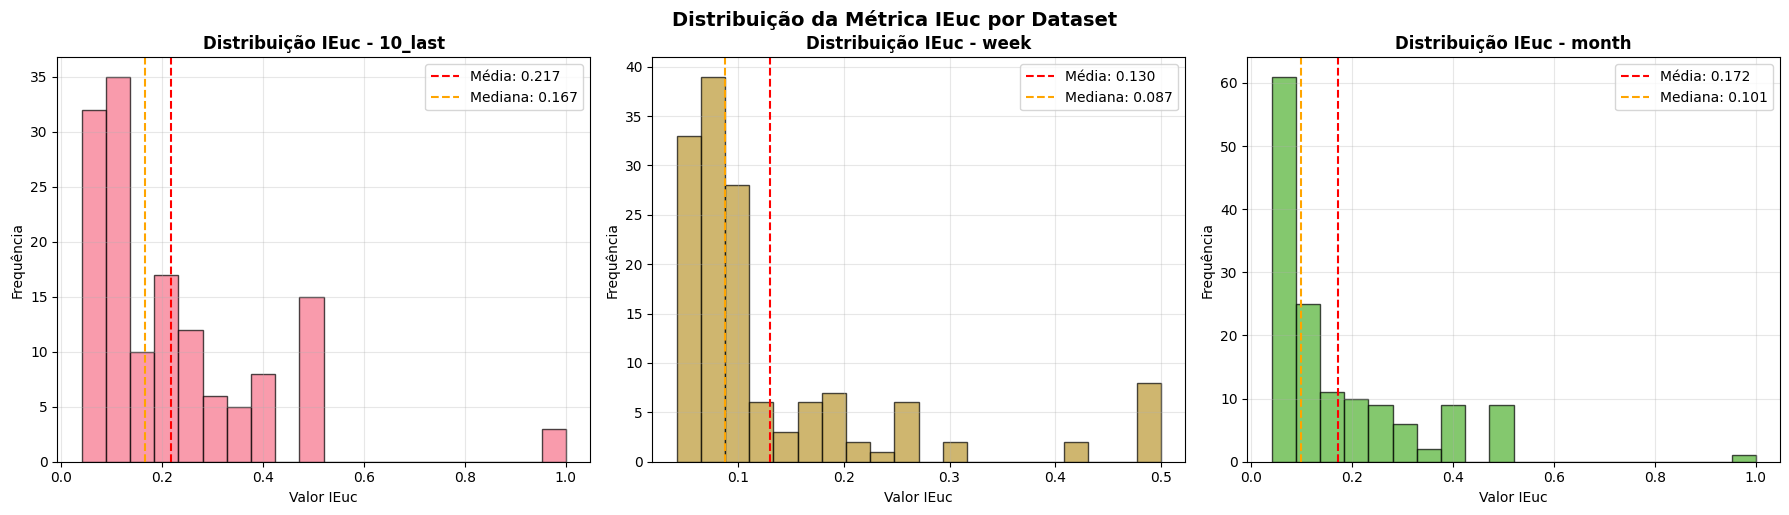

✅ Análise da distribuição de IEuc criada


In [40]:
# Análise detalhada da distribuição de IEuc por dataset
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, (name, df) in enumerate(dataframes.items()):
    # Histogram da distribuição de IEuc
    ieuc_values = df['ieuc']

    axes[i].hist(ieuc_values, bins=20, alpha=0.7, color=f'C{i}', edgecolor='black')
    axes[i].axvline(ieuc_values.mean(), color='red', linestyle='--',
                   label=f'Média: {ieuc_values.mean():.3f}')
    axes[i].axvline(ieuc_values.median(), color='orange', linestyle='--',
                   label=f'Mediana: {ieuc_values.median():.3f}')

    axes[i].set_title(f'Distribuição IEuc - {name}', fontweight='bold')
    axes[i].set_xlabel('Valor IEuc')
    axes[i].set_ylabel('Frequência')
    axes[i].legend()
    axes[i].grid(True, alpha=0.3)

plt.tight_layout()
plt.suptitle('Distribuição da Métrica IEuc por Dataset', fontsize=14, fontweight='bold', y=1.02)
plt.show()

print("✅ Análise da distribuição de IEuc criada")

## Análise de Correlação e Insights

Vamos analisar as correlações entre as diferentes métricas e extrair insights dos resultados.

In [41]:
# Análise de correlação entre métricas para cada dataset
print("=== ANÁLISE DE CORRELAÇÃO ===\n")

for name, df in dataframes.items():
    print(f"📊 Dataset: {name}")

    # Matriz de correlação
    corr_cols = ['recall_at_1', 'recall_at_5', 'ieuc', 'tokens_spent']
    correlation_matrix = df[corr_cols].corr()

    print(f"Matriz de Correlação:")
    print(correlation_matrix.round(3).to_string())

    # Insights específicos
    recall_1_true = df[df['recall_at_1'] == True]
    recall_5_true = df[df['recall_at_5'] == True]
    both_false = df[(df['recall_at_1'] == False) & (df['recall_at_5'] == False)]

    print(f"\nEstatísticas:")
    print(f"  - Casos com Recall@1 = True: {len(recall_1_true)} ({len(recall_1_true)/len(df)*100:.1f}%)")
    print(f"  - Casos com Recall@5 = True: {len(recall_5_true)} ({len(recall_5_true)/len(df)*100:.1f}%)")
    print(f"  - Casos com ambos False: {len(both_false)} ({len(both_false)/len(df)*100:.1f}%)")

    if len(recall_1_true) > 0:
        print(f"  - Tokens médios quando Recall@1 = True: {recall_1_true['tokens_spent'].mean():.1f}")
    if len(both_false) > 0:
        print(f"  - Tokens médios quando ambos False: {both_false['tokens_spent'].mean():.1f}")

    print("-" * 60)

=== ANÁLISE DE CORRELAÇÃO ===

📊 Dataset: 10_last
Matriz de Correlação:
              recall_at_1  recall_at_5   ieuc  tokens_spent
recall_at_1         1.000        0.428  0.630         0.025
recall_at_5         0.428        1.000  0.427         0.080
ieuc                0.630        0.427  1.000         0.059
tokens_spent        0.025        0.080  0.059         1.000

Estatísticas:
  - Casos com Recall@1 = True: 3 (2.1%)
  - Casos com Recall@5 = True: 15 (10.5%)
  - Casos com ambos False: 128 (89.5%)
  - Tokens médios quando Recall@1 = True: 1083.3
  - Tokens médios quando ambos False: 1064.4
------------------------------------------------------------
📊 Dataset: week
Matriz de Correlação:
              recall_at_1  recall_at_5   ieuc  tokens_spent
recall_at_1           NaN          NaN    NaN           NaN
recall_at_5           NaN        1.000  0.409         0.051
ieuc                  NaN        0.409  1.000         0.472
tokens_spent          NaN        0.051  0.472         1.000

/var/folders/8j/gf55sc1x6k954xq9x305c_7w0000gn/T/ipykernel_46847/2600221593.py:32: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


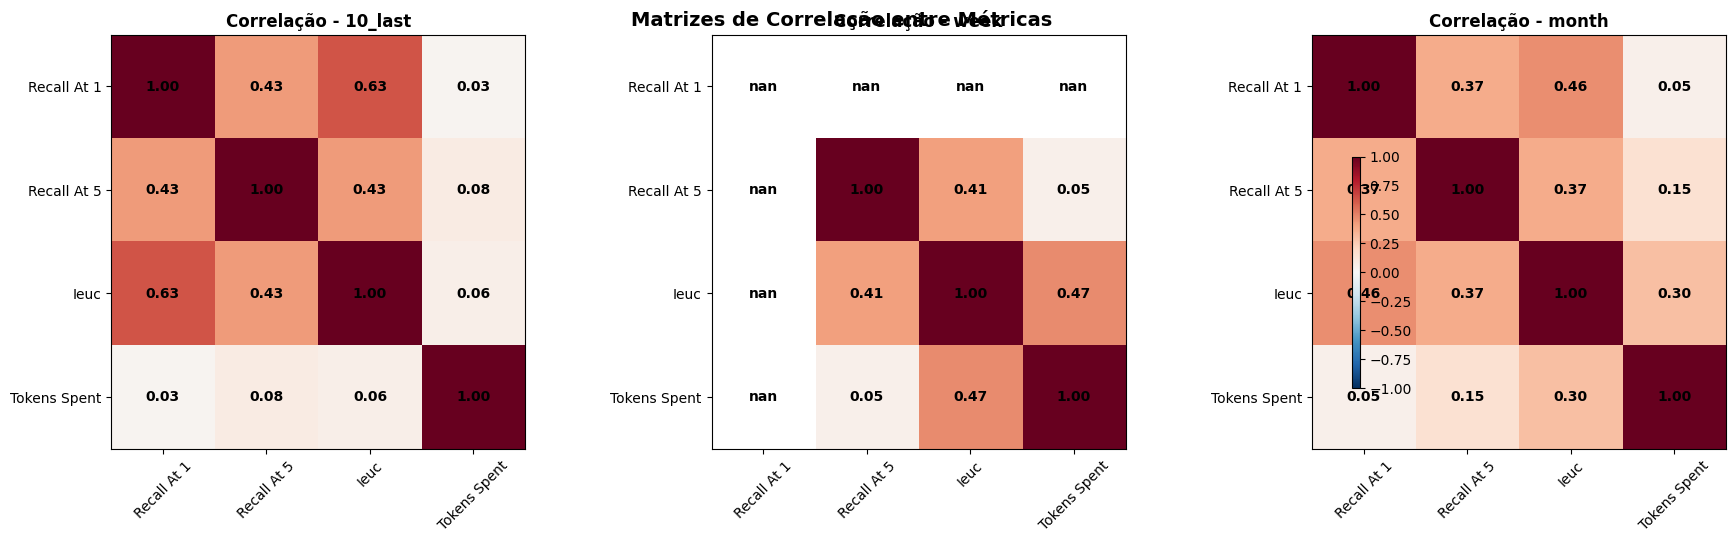

✅ Matrizes de correlação visualizadas


In [42]:
# Visualização das matrizes de correlação
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, (name, df) in enumerate(dataframes.items()):
    corr_cols = ['recall_at_1', 'recall_at_5', 'ieuc', 'tokens_spent']
    correlation_matrix = df[corr_cols].corr()

    # Converter booleanos para numéricos para melhor correlação
    df_numeric = df.copy()
    df_numeric['recall_at_1'] = df_numeric['recall_at_1'].astype(int)
    df_numeric['recall_at_5'] = df_numeric['recall_at_5'].astype(int)

    correlation_matrix = df_numeric[corr_cols].corr()

    im = axes[i].imshow(correlation_matrix, cmap='RdBu_r', vmin=-1, vmax=1)

    # Adicionar valores na matriz
    for j in range(len(corr_cols)):
        for k in range(len(corr_cols)):
            text = axes[i].text(k, j, f'{correlation_matrix.iloc[j, k]:.2f}',
                              ha="center", va="center", color="black", fontweight='bold')

    axes[i].set_xticks(range(len(corr_cols)))
    axes[i].set_yticks(range(len(corr_cols)))
    axes[i].set_xticklabels([col.replace('_', ' ').title() for col in corr_cols], rotation=45)
    axes[i].set_yticklabels([col.replace('_', ' ').title() for col in corr_cols])
    axes[i].set_title(f'Correlação - {name}', fontweight='bold')

# Adicionar colorbar
fig.colorbar(im, ax=axes, shrink=0.6, aspect=30)

plt.tight_layout()
plt.suptitle('Matrizes de Correlação entre Métricas', fontsize=14, fontweight='bold', y=1.02)
plt.show()

print("✅ Matrizes de correlação visualizadas")

In [43]:
# Conclusões e exportação dos resultados
print("=== CONCLUSÕES E RANKING ===\n")

# Criar ranking baseado nas métricas
metrics_df = summary_df.copy()
metrics_df['Score_Combinado'] = (
    metrics_df['Recall@1'] * 0.4 +  # Peso maior para Recall@1
    metrics_df['Recall@5'] * 0.3 +  # Peso médio para Recall@5
    metrics_df['IEuc'] * 0.3        # Peso para eficiência
)

# Ranking por score combinado
ranking = metrics_df.sort_values('Score_Combinado', ascending=False)

print("🏆 RANKING DOS DATASETS (por Score Combinado):")
for i, (dataset, row) in enumerate(ranking.iterrows(), 1):
    print(f"{i}º lugar: {dataset}")
    print(f"   Score Combinado: {row['Score_Combinado']:.4f}")
    print(f"   Recall@1: {row['Recall@1']*100:.1f}% | Recall@5: {row['Recall@5']*100:.1f}% | IEuc: {row['IEuc']:.3f}")
    print(f"   Eficiência: {row['Tokens (Mean)']:.0f} tokens/tarefa")
    print()

# Salvar resultados em CSV
output_path = '../../data/metrics_summary.csv'
metrics_df.to_csv(output_path, index=True)
print(f"✅ Resultados salvos em: {output_path}")

# Insights finais
best_dataset = ranking.index[0]
print(f"🎯 MELHOR DATASET: {best_dataset}")
print(f"   - Apresenta o melhor equilíbrio entre precisão e eficiência")
print(f"   - Score combinado: {ranking.iloc[0]['Score_Combinado']:.4f}")

# Análise de eficiência
most_efficient = metrics_df.loc[metrics_df['Tokens (Mean)'].idxmin()]
print(f"\n⚡ MAIS EFICIENTE EM TOKENS: {most_efficient.name}")
print(f"   - {most_efficient['Tokens (Mean)']:.0f} tokens por tarefa em média")

=== CONCLUSÕES E RANKING ===

🏆 RANKING DOS DATASETS (por Score Combinado):
1º lugar: 10_last
   Score Combinado: 0.1051
   Recall@1: 2.1% | Recall@5: 10.5% | IEuc: 0.217
   Eficiência: 1067 tokens/tarefa

2º lugar: month
   Score Combinado: 0.0692
   Recall@1: 0.7% | Recall@5: 4.9% | IEuc: 0.172
   Eficiência: 581 tokens/tarefa

3º lugar: week
   Score Combinado: 0.0474
   Recall@1: 0.0% | Recall@5: 2.8% | IEuc: 0.130
   Eficiência: 520 tokens/tarefa

✅ Resultados salvos em: ../../data/metrics_summary.csv
🎯 MELHOR DATASET: 10_last
   - Apresenta o melhor equilíbrio entre precisão e eficiência
   - Score combinado: 0.1051

⚡ MAIS EFICIENTE EM TOKENS: week
   - 520 tokens por tarefa em média
